# Object oriented programming (OOP): Reinforcement Learning

Example from: https://towardsdatascience.com/reinforcement-learning-implement-grid-world-from-scratch-c5963765ebff

## Libraries and settings

In [7]:
# Libraries
import numpy as np
from IPython.display import clear_output
import matplotlib.pyplot as plt

# Global variables
BOARD_ROWS = 3
BOARD_COLS = 4
WIN_STATE = (0, 3)
LOSE_STATE = (1, 3)
START = (2, 0)
DETERMINISTIC = True


## Rule for the agent

Your agent starts at the left-bottom corner(the 'start' sign) and ends at either +1 or -1 which is the corresponding reward. At each step, the agent has 4 possible actions including up, down, left and right, whereas the black cell is a wall where your agent won’t be able to penetrate through. In order to make it more straight forward, our first implementation assumes that each action is deterministic, that is, the agent will go where it intends to go. For instance, when the agent decides to take action up at (2, 0), it will land in (1, 0) rather than (2, 1) or elsewhere. (We will add uncertainty in out second implementation) However, it the agents hit the wall, it will remain at the same position.

## Plot the board

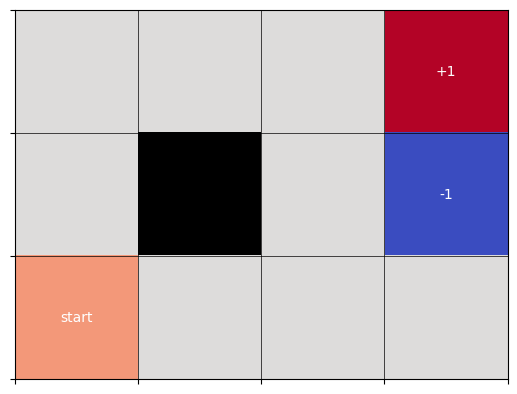

In [8]:
# Initialize the board with zeros
board = np.zeros((BOARD_ROWS, BOARD_COLS))

# Mark the start, win, and lose states on the grid
board[START] = 0.5
board[WIN_STATE] = 1
board[LOSE_STATE] = -1

# Block cell
block_state = (1, 1)
board[block_state] = np.nan  # Use NaN for blocked cells

# Create the figure and axes
fig, ax = plt.subplots()

# Use a heatmap to show the different states
cmap = plt.cm.coolwarm
cmap.set_bad('black', 1.)
heatmap = ax.imshow(board, cmap=cmap, interpolation='nearest')

# Add text in each cell
for i in range(BOARD_ROWS):
    for j in range(BOARD_COLS):
        if (i, j) == WIN_STATE:
            text = ax.text(j, i, '+1', ha='center', va='center', color='white')
        elif (i, j) == LOSE_STATE:
            text = ax.text(j, i, '-1', ha='center', va='center', color='white')
        elif (i, j) == START:
            text = ax.text(j, i, 'start', ha='center', va='center', color='white')

# Set the grid
ax.set_xticks(np.arange(-.5, BOARD_COLS, 1), minor=False)
ax.set_yticks(np.arange(-.5, BOARD_ROWS, 1), minor=False)
ax.grid(color="black", linestyle='-', linewidth=0.5)
ax.tick_params(which="minor", size=0)

# Remove the tick labels
ax.set_xticklabels([])
ax.set_yticklabels([])

# Show the plot
plt.show()


## State and Agent Classes with their methods

In [9]:
class State:

    def __init__(self, state=START):
        self.board = np.zeros([BOARD_ROWS, BOARD_COLS])
        self.board[1, 1] = -1
        self.state = state
        self.isEnd = False
        self.determine = DETERMINISTIC

    def giveReward(self):
        if self.state == WIN_STATE:
            return 1
        elif self.state == LOSE_STATE:
            return -1
        else:
            return 0

    def isEndFunc(self):
        if (self.state == WIN_STATE) or (self.state == LOSE_STATE):
            self.isEnd = True

    def nxtPosition(self, action):
        """
        action: up, down, left, right
        -------------
        0 | 1 | 2| 3|
        1 |
        2 |
        return next position
        """
        if self.determine:
            if action == "up":
                nxtState = (self.state[0] - 1, self.state[1])
            elif action == "down":
                nxtState = (self.state[0] + 1, self.state[1])
            elif action == "left":
                nxtState = (self.state[0], self.state[1] - 1)
            else:
                nxtState = (self.state[0], self.state[1] + 1)
            # if next state legal
            if (nxtState[0] >= 0) and (nxtState[0] <= (BOARD_ROWS -1)):
                if (nxtState[1] >= 0) and (nxtState[1] <= (BOARD_COLS -1)):
                    if nxtState != (1, 1):
                        return nxtState
            return self.state

    def showBoard(self):
        self.board[self.state] = 1
        for i in range(0, BOARD_ROWS):
            print('-----------------')
            out = '| '
            for j in range(0, BOARD_COLS):
                if self.board[i, j] == 1:
                    token = '*'
                if self.board[i, j] == -1:
                    token = 'z'
                if self.board[i, j] == 0:
                    token = '0'
                out += token + ' | '
            print(out)
        print('-----------------')


# Agent
class Agent:

    def __init__(self):
        self.states = []
        self.actions = ["up", "down", "left", "right"]
        self.State = State()
        self.lr = 0.2 # learning rate
        self.exp_rate = 0.3 # exploration rate

        # initial state reward
        self.state_values = {}
        for i in range(BOARD_ROWS):
            for j in range(BOARD_COLS):
                self.state_values[(i, j)] = 0  # set initial value to 0

    def chooseAction(self):
        # choose action with most expected value
        mx_nxt_reward = 0
        action = ""

        if np.random.uniform(0, 1) <= self.exp_rate:
            action = np.random.choice(self.actions)
        else:
            # greedy action
            for a in self.actions:
                # if the action is deterministic
                nxt_reward = self.state_values[self.State.nxtPosition(a)]
                if nxt_reward >= mx_nxt_reward:
                    action = a
                    mx_nxt_reward = nxt_reward
        return action

    def takeAction(self, action):
        position = self.State.nxtPosition(action)
        return State(state=position)

    def reset(self):
        self.states = []
        self.State = State()

    def play(self, rounds=10):
        i = 0
        while i < rounds:
            # to the end of game back propagate reward
            if self.State.isEnd:
                # back propagate
                reward = self.State.giveReward()
                # explicitly assign end state to reward values
                self.state_values[self.State.state] = reward  # this is optional
                print("Game End Reward", reward)
                for s in reversed(self.states):
                    reward = self.state_values[s] + self.lr * (reward - self.state_values[s])
                    self.state_values[s] = round(reward, 3)
                self.reset()
                i += 1
            else:
                action = self.chooseAction()
                # append trace
                self.states.append(self.State.nxtPosition(action))
                print("current position {} action {}".format(self.State.state, action))
                # by taking the action, it reaches the next state
                self.State = self.takeAction(action)
                # mark is end
                self.State.isEndFunc()
                print("nxt state", self.State.state)
                # print("---------------------")

    def showValues(self):
        for i in range(0, BOARD_ROWS):
            print('----------------------------------')
            out = '| '
            for j in range(0, BOARD_COLS):
                out += str(self.state_values[(i, j)]).ljust(6) + ' | '
            print(out)
        print('----------------------------------')

## Create class instance and run the model

In [12]:
ag = Agent()
ag.play(100)

print(ag.showValues())


current position (2, 0) action right
nxt state (2, 1)
current position (2, 1) action up
nxt state (2, 1)
current position (2, 1) action right
nxt state (2, 2)
current position (2, 2) action up
nxt state (1, 2)
current position (1, 2) action right
nxt state (1, 3)
Game End Reward -1
current position (2, 0) action left
nxt state (2, 0)
current position (2, 0) action left
nxt state (2, 0)
current position (2, 0) action right
nxt state (2, 1)
current position (2, 1) action left
nxt state (2, 0)
current position (2, 0) action up
nxt state (1, 0)
current position (1, 0) action down
nxt state (2, 0)
current position (2, 0) action left
nxt state (2, 0)
current position (2, 0) action left
nxt state (2, 0)
current position (2, 0) action right
nxt state (2, 1)
current position (2, 1) action left
nxt state (2, 0)
current position (2, 0) action left
nxt state (2, 0)
current position (2, 0) action right
nxt state (2, 1)
current position (2, 1) action left
nxt state (2, 0)
current position (2, 0) act

current position (1, 0) action down
nxt state (2, 0)
current position (2, 0) action up
nxt state (1, 0)
current position (1, 0) action right
nxt state (1, 0)
current position (1, 0) action right
nxt state (1, 0)
current position (1, 0) action right
nxt state (1, 0)
current position (1, 0) action right
nxt state (1, 0)
current position (1, 0) action right
nxt state (1, 0)
current position (1, 0) action right
nxt state (1, 0)
current position (1, 0) action right
nxt state (1, 0)
current position (1, 0) action down
nxt state (2, 0)
current position (2, 0) action up
nxt state (1, 0)
current position (1, 0) action right
nxt state (1, 0)
current position (1, 0) action right
nxt state (1, 0)
current position (1, 0) action right
nxt state (1, 0)
current position (1, 0) action right
nxt state (1, 0)
current position (1, 0) action left
nxt state (1, 0)
current position (1, 0) action right
nxt state (1, 0)
current position (1, 0) action right
nxt state (1, 0)
current position (1, 0) action right


## Interpretation of results

The three lines in the result table represent the state values for a 3-row grid environment in the agent-based model. Each row corresponds to a different horizontal level in the grid, and each cell within a row represents a specific position or state in that level. The grid layout and the values illustrate how the agent has learned to value each position based on its experiences of rewards and penalties throughout its exploration of the environment.<br>

<div style="color: blue;">Example output:</div><br>
<table border="1">
  <tr>
    <td>0.933</td>
    <td>0.935</td>
    <td>0.920</td>
    <td>1.0</td>
  </tr>
  <tr>
    <td>0.931</td>
    <td>0</td>
    <td>0.729</td>
    <td>-1.0</td>
  </tr>
  <tr>
    <td>0.929</td>
    <td>0.927</td>
    <td>0.911</td>
    <td>0.662</td>
  </tr>
</table>

### Jupyter notebook --footer info-- (please always provide this at the end of each notebook)

In [11]:
import os
import platform
import socket
from platform import python_version
from datetime import datetime

print('-----------------------------------')
print(os.name.upper())
print(platform.system(), '|', platform.release())
print('Datetime:', datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
print('Python Version:', python_version())
print('-----------------------------------')

-----------------------------------
NT
Windows | 10
Datetime: 2024-04-10 16:56:49
Python Version: 3.10.13
-----------------------------------
